<a href="https://colab.research.google.com/github/Driptoe0606/ChemGAN-challenge/blob/master/Drug_Designing_Project_Part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Retrieval From ChEMBL Database**

https://jcheminf.biomedcentral.com/articles/10.1186/s13321-019-0351-x


**Learning and Training Objectives**
1. Retrieving compound data and activities from ChEMBL for a protein (receptor) of your choice.
**Understanding units**

**1. IC50** is a standared unit used in biochemical assays for inhibition. It stands for Inhibitory concentration at 50 or Half maximal inhibitory concentration. The lower value indicates higher potency of a drug. You may also see **pIC50**, that is = -log10(IC50). It makes the opposite of IC50, meaning higher pIC50 means higher potency of a drug.

Let's begin,


##Pre-requisite Installation and Imports

In [1]:
! pip install chembl_webresource_client
! pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 46.5 MB/s eta 0:00:00


In [2]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

Creating some API tokens for target

In [4]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [5]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [50]:
uniprot_id = "P0DMV9"

In [7]:
# Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [8]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Heat shock 70 kDa protein 1,CHEMBL5460,SINGLE PROTEIN
1,Homo sapiens,Heat shock 70 kDa protein 1,CHEMBL5460,SINGLE PROTEIN
2,Homo sapiens,Heat shock 70 kDa protein 1A/1B,CHEMBL3885585,PROTEIN FAMILY


Below we will select the exact ChEMBL data via index options

In [9]:
target = targets.iloc[0]
target

,0
organism,Homo sapiens
pref_name,Heat shock 70 kDa protein 1
target_chembl_id,CHEMBL5460
target_type,SINGLE PROTEIN


In [10]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")
# NBVAL_CHECK_OUTPUT

The target ChEMBL ID is CHEMBL5460


Fetch some important variable of the data for ourself.

In [11]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 52, <class 'chembl_webresource_client.query_set.QuerySet'>


Each entry in our bioactivity set holds the following information:

In [12]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 3909864,
 'assay_chembl_id': 'CHEMBL1613848',
 'assay_description': 'PUBCHEM_BIOASSAY: TR-FRET secondary assay for HTS discovery of chemical inhibitors of Hsp70. (Class of assay: confirmatory) [Related pubchem assays: 583 ]',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL496',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '19200.0',
 'target_chembl_id': 'CHEMBL5460',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'um',
 'value': '19.2'}

Download the dataset

In [13]:
#Downloading Data
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (52, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,3909864,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL496,=,nM,19200.0,CHEMBL5460,Homo sapiens,IC50,um,19.2
1,3909868,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1539325,=,nM,8320.0,CHEMBL5460,Homo sapiens,IC50,um,8.32
2,3909869,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1373655,=,nM,17400.0,CHEMBL5460,Homo sapiens,IC50,um,17.4
3,3909872,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1449293,=,nM,11400.0,CHEMBL5460,Homo sapiens,IC50,um,11.4
4,3909874,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL213432,=,nM,18500.0,CHEMBL5460,Homo sapiens,IC50,um,18.5


It is possible that some of the rows show redundant data, but do not worry we will remove that later

**Now we want to know how many different units are present in the data**

In [14]:
bioactivities_df["units"].unique()

array(['um', 'uM'], dtype=object)

Below we will do some tweaking with units to make them uniform

In [15]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,3909864,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL496,=,nM,19200.0,CHEMBL5460,Homo sapiens,IC50
1,3909868,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1539325,=,nM,8320.0,CHEMBL5460,Homo sapiens,IC50
2,3909869,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1373655,=,nM,17400.0,CHEMBL5460,Homo sapiens,IC50
3,3909872,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1449293,=,nM,11400.0,CHEMBL5460,Homo sapiens,IC50
4,3909874,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL213432,=,nM,18500.0,CHEMBL5460,Homo sapiens,IC50


**Data Processing and Filteration**

Delete entries with missing and duplicate values.

Reset index number and rename columns.



In [16]:
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,object
target_chembl_id,object
target_organism,object


In [17]:
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

,0
activity_id,int64
assay_chembl_id,object
assay_description,object
assay_type,object
molecule_chembl_id,object
relation,object
standard_units,object
standard_value,float64
target_chembl_id,object
target_organism,object


In [18]:
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (52, 11)


In [19]:
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [20]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [21]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (52, 11)


In [22]:
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (45, 11)


In [23]:
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,3909864,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL496,=,nM,19200.0,CHEMBL5460,Homo sapiens,IC50
1,3909868,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1539325,=,nM,8320.0,CHEMBL5460,Homo sapiens,IC50
2,3909869,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1373655,=,nM,17400.0,CHEMBL5460,Homo sapiens,IC50
3,3909872,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1449293,=,nM,11400.0,CHEMBL5460,Homo sapiens,IC50
4,3909874,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL213432,=,nM,18500.0,CHEMBL5460,Homo sapiens,IC50


In [24]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,3909864,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL496,=,nM,19200.0,CHEMBL5460,Homo sapiens,IC50
1,3909868,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1539325,=,nM,8320.0,CHEMBL5460,Homo sapiens,IC50
2,3909869,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1373655,=,nM,17400.0,CHEMBL5460,Homo sapiens,IC50
3,3909872,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL1449293,=,nM,11400.0,CHEMBL5460,Homo sapiens,IC50
4,3909874,CHEMBL1613848,PUBCHEM_BIOASSAY: TR-FRET secondary assay for ...,B,CHEMBL213432,=,nM,18500.0,CHEMBL5460,Homo sapiens,IC50


In [25]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (45, 11)


**Fetch compound data from ChEMBL**

Let’s have a look at the compounds from ChEMBL which we have defined so far. bioactivity data for: We are going to fetch compound ChEMBL IDs and structures for the compounds linked to our filtered bioactivity data.

In [26]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

**Download Compounds**

In [27]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/45 [00:00<?, ?it/s]

In [28]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (45, 2)


In [29]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL496,{'canonical_smiles': 'Oc1c(Cl)cc(Cl)c(Cl)c1Cc1...
2,CHEMBL269410,{'canonical_smiles': 'Nc1cccc2c1C(=O)N(c1ccccc...
3,CHEMBL14249,{'canonical_smiles': 'Nc1ncnc2c1ncn2[C@@H]1O[C...
4,CHEMBL201289,{'canonical_smiles': 'O=C(O)C1Nc2ccc(Br)cc2C2C...


In [30]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (45, 2)


In [31]:
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (45, 2)


In [32]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [33]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (45, 2)


In [34]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (45, 2)


**Let's output compound bioactivity data**

In [35]:
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 45


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [36]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 45


Index(['molecule_chembl_id', 'smiles'], dtype='object')

**Lets merge both the datasets**

Merge to contain, molecule ID, IC50, Units, and canonical smiles

In [37]:
# Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 45 entries.


In [38]:
output_df.dtypes

,0
molecule_chembl_id,object
IC50,float64
units,object
smiles,object


In [39]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL496,19200.0,nM,Oc1c(Cl)cc(Cl)c(Cl)c1Cc1c(O)c(Cl)cc(Cl)c1Cl
1,CHEMBL1539325,8320.0,nM,CC1(C)CCCN(C(=O)c2coc(=O)c(Br)c2)C1
2,CHEMBL1373655,17400.0,nM,CC1=NN(c2cccc(C(=O)O)c2)C(=O)/C1=C\C=C\c1ccco1
3,CHEMBL1449293,11400.0,nM,COc1cccc(C(=O)NC2CC3CCCC(C2)N3CC(=O)Nc2ccccc2)...
4,CHEMBL213432,18500.0,nM,Cc1ccc(C)n1-c1cccc(C(=O)O)c1
5,CHEMBL1463596,16000.0,nM,NC(=O)COc1ccc(C2c3c(oc4ccccc4c3=O)C(=O)N2CC2CC...
6,CHEMBL1509453,12400.0,nM,Cc1ccc(C(=O)ONc2ccc(N=NC(=O)c3ccccc3O)cc2)cc1
7,CHEMBL1430473,22400.0,nM,O=C(O)C1Nc2c(O)cc(Cl)c([N+](=O)[O-])c2C2C=CCC12
8,CHEMBL1527023,35200.0,nM,CC(=O)Nc1ccc2c(c1)C1C=CCC1C(C(=O)O)N2
9,CHEMBL1333555,8360.0,nM,O=C(O)C1Nc2c(cccc2C(F)(F)F)C2C=CCC12


**Convert IC50 values into pIC50 and put it in an extra column**

In [40]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [41]:
# Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

In [42]:
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL496,19200.0,nM,Oc1c(Cl)cc(Cl)c(Cl)c1Cc1c(O)c(Cl)cc(Cl)c1Cl,4.716699
1,CHEMBL1539325,8320.0,nM,CC1(C)CCCN(C(=O)c2coc(=O)c(Br)c2)C1,5.079877
2,CHEMBL1373655,17400.0,nM,CC1=NN(c2cccc(C(=O)O)c2)C(=O)/C1=C\C=C\c1ccco1,4.759451
3,CHEMBL1449293,11400.0,nM,COc1cccc(C(=O)NC2CC3CCCC(C2)N3CC(=O)Nc2ccccc2)...,4.943095
4,CHEMBL213432,18500.0,nM,Cc1ccc(C)n1-c1cccc(C(=O)O)c1,4.732828


**Distribution Based on IpIC50**

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

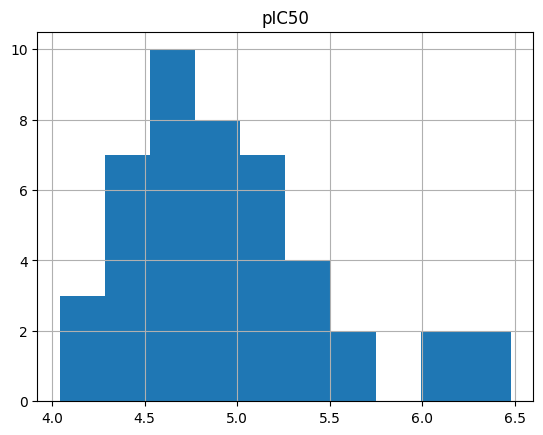

In [43]:
output_df.hist(column="pIC50")

In the next steps, I added a column for RDKit molecule objects to our DataFrame and look at the structures of the molecules with the highest pIC50 values.

In [44]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

Failed to patch pandas - unable to change molecule rendering


In [45]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

In [46]:
output_df.drop("smiles", axis=1).head(3)

,molecule_chembl_id,IC50,units,pIC50,ROMol
0,CHEMBL502775,332.0,nM,6.478862,<rdkit.Chem.rdchem.Mol object at 0x7ee3679d9f50>
1,CHEMBL1481974,578.0,nM,6.238072,<rdkit.Chem.rdchem.Mol object at 0x7ee3679d9930>
2,CHEMBL471004,634.0,nM,6.197911,<rdkit.Chem.rdchem.Mol object at 0x7ee3679d97e0>


In [47]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (45, 5)


**Save Dataset for Next Session**

In [48]:
output_df.to_csv("/content/sample_data/HSP70_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL502775,332.0,nM,O=C(O)/C=C/c1c2ccc(=O)c(O)c-2oc2c(O)c(O)ccc12,6.478862
1,CHEMBL1481974,578.0,nM,O=C(O)CCc1c2ccc(=O)c(O)c-2oc2c(O)c(O)ccc12,6.238072
2,CHEMBL471004,634.0,nM,CC1C2C=CC1C(c1c3ccc(=O)c(O)c-3oc3c(O)c(O)ccc13...,6.197911
3,CHEMBL6246,760.0,nM,O=c1oc2c(O)c(O)cc3c(=O)oc4c(O)c(O)cc1c4c23,6.119186
4,CHEMBL1409373,1970.0,nM,NS(=O)(=O)c1ccc2c(c1)C1C=CCC1C(C(=O)O)N2,5.705534


In [49]:
print(f"DataFrame shape: {output_df.shape}")
# NBVAL_CHECK_OUTPUT

DataFrame shape: (45, 5)
